In [1]:
import symbolica
from symbolica import S, E, N
from IPython.display import display_latex, Latex
import matplotlib.pyplot as plt
import numpy as np

In [2]:
i = symbolica.Expression.I
q1, q2, p11, p12, p21, p22, m = S('q1','q2', 'p11', 'p12','p21','p22', 'm')
eps = S('e') #greek letters dont work as expected, therefore use e

def pcr(E, p):
    return 1/(E**2-p**2 - m**2 + i*eps)

integrand = -i * pcr(q1, q2)*pcr(q1+p11, q2+p12)*pcr(q1-p21, q2-p22)

display_latex(Latex(integrand.to_latex()))

In [3]:
integrand_eval = integrand.evaluator({
    m:      symbolica.Expression.num(0),
    eps:    symbolica.Expression.num(1)/1000,
    p11:    symbolica.Expression.num(1),
    p12:    symbolica.Expression.num(0),
    p21:    symbolica.Expression.num(1),
    p22:    symbolica.Expression.num(0),
},{},
    [q1, q2])

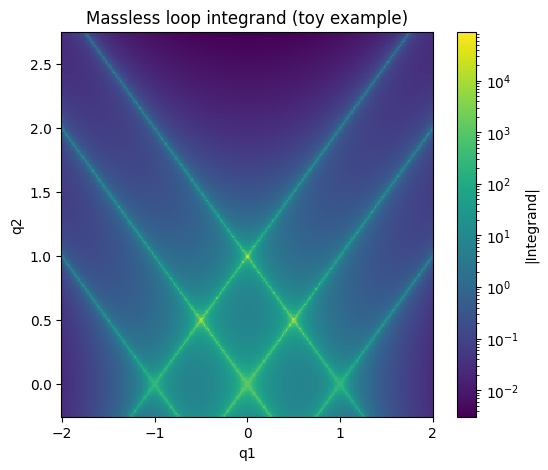

In [4]:
# Create a NumPy meshgrid for q1, q2
from matplotlib.colors import LogNorm


q1_vals = np.linspace(-2, 2, 300)
q2_vals = np.linspace(-0.25, 2.75, 300)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Evaluate the integrand on the grid
Z = np.zeros_like(Q1, dtype=np.complex128)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        Z[i,j] = integrand_eval.evaluate_complex([[Q1[i,j], Q2[i,j]]])[0][0]

# Plot the absolute value of the integrand
plt.figure(figsize=(6,5))
plt.pcolormesh(Q1, Q2, np.abs(Z), shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='|Integrand|')
plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Massless loop integrand (toy example)')
plt.show()

In [5]:
class SymbolicaLorenzVec:
    def __init__(self, symbols : list):
        self.symbols = symbols
    @staticmethod
    def from_name(name):
        symbols = [symbolica.S(f'{name}_{i}')for i in range(4)]
        return SymbolicaLorenzVec(symbols)
    
    def t(self):
        return self.symbols[0]

    def spacial(self):
        return SymbolicaVec(self.symbols[1:])
    
    def get_subs_dict(self, values):
        return {sym : N(num) for sym, num in zip(self.symbols, values)}
    
    def __add__(self, other):
        if isinstance(other, SymbolicaLorenzVec):
            return SymbolicaLorenzVec([a+b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __sub__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a-b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __mul__(self, other):
        if isinstance(other, SymbolicaLorenzVec):
            return self.symbols[0]*other.symbols[0]-self.spacial()*other.spacial()
        return [a*other for a in self.symbols]
    def __str__(self):
        return str(self.symbols)

class SymbolicaVec:
    def __init__(self, symbols : list):
        self.symbols = symbols
    @staticmethod
    def from_name(name):
        values = [symbolica.E(f'{name}_{i}')for i in range(1,4)]
        return SymbolicaVec(values)
    
    def __add__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a+b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __sub__(self, other):
        if isinstance(other, SymbolicaVec):
            return SymbolicaVec([a-b for a, b in zip(self.symbols, other.symbols)])
        return [a+other for a in self.symbols]
    def __mul__(self, other):
        if isinstance(other, SymbolicaVec):
            return sum(a*b for a, b in zip(self.symbols, other.symbols))
        return [a*other for a in self.symbols]
    def __str__(self):
        return str(self.symbols)
    
k = SymbolicaLorenzVec.from_name('k')
print(k * k)

k_0^2-(k_1^2+k_2^2+k_3^2)


In [6]:
class IntegrandBuilder:
    loop_momenta : list[SymbolicaLorenzVec]
    mass : complex
    integrand : SymbolicaVec
    pi = S('pi')
    def __init__(self): 
        self.loop_momenta = list(map(SymbolicaLorenzVec.from_name, ['q0', 'q1', 'q2']))
        self.mass = S('m')
        self.integrand = SymbolicaVec.from_name('k')
    
    def ose(self, i: int):
        temp = self.integrand - self.loop_momenta[i].spacial()
        return (temp*temp + self.mass * self.mass)**(N(1)/2)
    
    def eta(self, i: int, j: int):
        return self.ose(i) + self.ose(j) + self.loop_momenta[i].t() - self.loop_momenta[j].t()
    
    def improved_ltd_prefactor(self):
        return (4*self.pi)**N(-3)/(self.ose(0)*self.ose(1)*self.ose(2))

    def improved_ltd_part(self, i, j, k, l):
        return 1/(self.eta(i,j)*self.eta(k, l))
    
    def improved_ltd_expression(self) -> symbolica.Expression:
        return self.improved_ltd_prefactor()*(
            self.improved_ltd_part(0,1,0,2)+
            self.improved_ltd_part(1,0,2,0)+
            self.improved_ltd_part(1,0,1,2)+
            self.improved_ltd_part(0,1,2,1)+
            self.improved_ltd_part(2,0,2,1)+
            self.improved_ltd_part(0,2,1,2)
            )

b = IntegrandBuilder()
integrand = b.improved_ltd_expression().evaluator({},{},[b.pi, b.mass,] + [sym for m in b.loop_momenta for sym in m.symbols] + b.integrand.symbols)

print(integrand.get_instructions())

integrand.evaluate([[np.pi,0.02,0,0,0,0,-0.005,0,0,0.005,0.005,0,0,0.005,0.1,0.2,0.3]])
#reproduces result from theoretical exercises!

([('mul', ('out', 0), [('param', 0), ('param', 0)]), ('mul', ('temp', 1), [('param', 6), ('const', 2)]), ('mul', ('temp', 2), [('param', 7), ('const', 2)]), ('add', ('temp', 2), [('param', 14), ('temp', 2)]), ('mul', ('temp', 2), [('temp', 2), ('temp', 2)]), ('mul', ('temp', 3), [('param', 8), ('const', 2)]), ('add', ('temp', 3), [('param', 15), ('temp', 3)]), ('mul', ('temp', 3), [('temp', 3), ('temp', 3)]), ('mul', ('temp', 4), [('param', 9), ('const', 2)]), ('add', ('temp', 4), [('param', 16), ('temp', 4)]), ('mul', ('temp', 4), [('temp', 4), ('temp', 4)]), ('mul', ('temp', 5), [('param', 1), ('param', 1)]), ('add', ('temp', 2), [('temp', 2), ('temp', 3), ('temp', 4), ('temp', 5)]), ('powf', ('temp', 3), ('temp', 2), ('const', 3)), ('add', ('temp', 4), [('param', 6), ('temp', 3)]), ('add', ('temp', 1), [('temp', 1), ('temp', 3)]), ('mul', ('temp', 3), [('param', 3), ('const', 2)]), ('add', ('temp', 3), [('param', 14), ('temp', 3)]), ('mul', ('temp', 3), [('temp', 3), ('temp', 3)]), 

[[0.10608105036379605]]